# Redes Convolucionais com dados multi-rótulos


Antes de iniciar a execução do código faça a seguinte alteração: Menu: **Ambiente de execução -> Alterar o tipo de ambiente de execução -> GPU**

Cada instância do conjunto de dados pode ser classificada em mais de uma categoria. Considerando, por exemplo imagens de carros, podemos almejar que a rede convolucional tenha como saída o modelo e a cor do veículo. Sendo assim, temos X = {x1, x2, ..., xn} como input da rede e não mais apenas um respectivo Y = {y1, y2, ..., yn}. É necessáario modelar várias camadas de saída para uma única entrada de dados. Apesar de ser possível modelar saída combinadas de modelos por cores, este tipo de abordagem pode levar à memorização do conjunto de treinamento e exige maior representatividade.

**Vamos supor:**
modelos (Gol, Civic e HB20) e cores (branco, prata e preto)

**Possíveis modelos:**
2 camadas de saída em que cada output possui 3 neurônios ou
1 camada de saída com 9 neurônios (gol branco, gol prata, gol preto, ....)

In [ ]:
import numpy as np

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, Dense
from keras.datasets import mnist
from keras.utils import to_categorical

import matplotlib.pyplot as plt

from numpy.random import seed
from tensorflow.random import set_seed

**Carregando os dados:**

Neste exemplo, vamos utilizar a base de dados MNIST. De forma convencional, esta base possui dígitos (0 a 9) brancos em um fundo preto. Mas, para nossa aplicação, queremos classificar os dígitos e tambem a cor (branco ou preto). Então, vamos criar um conjunto de dados complementar com dígitos pretos e fundo branco.

Loading MNIST images ...
	Training image set shape:  (120000, 28, 28, 1)
	Training number shape:  (120000, 10)
	Training color shape:  (120000, 2)
	Testing image set shape:  (20000, 28, 28, 1)
	Testing number shape:  (20000, 10)
	Testing color shape:  (20000, 2)


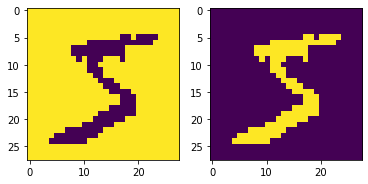

In [ ]:
def definingColor(X, color):
    XX = np.empty_like(X)
    if color == "white":
      XX[X < 127] = 0
      XX[X >= 127] = 255
      Y = np.zeros(X.shape[0])
    else:
      XX[X < 127] = 255
      XX[X >= 127] = 0
      Y = np.ones(X.shape[0])
    XX = XX.reshape(*XX.shape, 1) 
    return XX, Y

print("Loading MNIST images ...")
(Xtrain, YtrainNumber), (Xtest, YtestNumber) = mnist.load_data()

XtrainBlack, YtrainBlack = definingColor(Xtrain, "black")
XtrainWhite, YtrainWhite = definingColor(Xtrain, "white")
XtestBlack, YtestBlack = definingColor(Xtest, "black")
XtestWhite, YtestWhite = definingColor(Xtest, "white")

Xtrain = np.concatenate((XtrainBlack, XtrainWhite), axis=0)
YtrainNumber = np.concatenate((YtrainNumber, YtrainNumber), axis=0)
YtrainColor = np.concatenate((YtrainBlack, YtrainWhite), axis=0)

Xtest = np.concatenate((XtestBlack, XtestWhite), axis=0)
YtestNumber = np.concatenate((YtestNumber, YtestNumber), axis=0)
YtestColor = np.concatenate((YtestBlack, YtestWhite), axis=0)

YtrainNumber = to_categorical(YtrainNumber)
YtestNumber = to_categorical(YtestNumber)
YtrainColor = to_categorical(YtrainColor)
YtestColor = to_categorical(YtestColor)

print('\tTraining image set shape: ', Xtrain.shape)
print('\tTraining number shape: ', YtrainNumber.shape)
print('\tTraining color shape: ', YtrainColor.shape)

print('\tTesting image set shape: ', Xtest.shape)
print('\tTesting number shape: ', YtestNumber.shape)
print('\tTesting color shape: ', YtestColor.shape)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(XtrainBlack[0][:, :, 0])
axes[1].imshow(XtrainWhite[0][:, :, 0])
plt.show()

**Treinando uma CNN com multi rótulos:**

Defining the CNN from scratch ...
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
_____________________________________________________

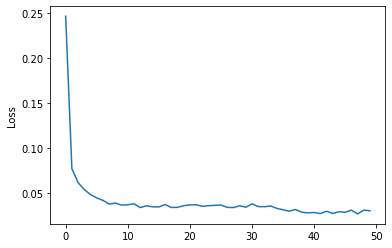

In [ ]:
print("Defining the CNN from scratch ...")
input_img = Input(shape=(28, 28, 1,))

cnnScratch = Conv2D(64, kernel_size=(3,3), strides=(2, 2), padding='same', activation='relu')(input_img)
cnnScratch = Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(cnnScratch)
cnnScratch = Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(cnnScratch)
cnnScratch = MaxPooling2D(pool_size=(2, 2))(cnnScratch)
cnnScratch = Flatten(name='code')(cnnScratch)
cnnNumber = Dense(10, activation='softmax', name='predNumber')(cnnScratch)
cnnColor = Dense(2, activation='softmax', name='predColor')(cnnScratch)

seed(1)
set_seed(2)

cnn = Model(inputs=input_img, outputs=[cnnNumber, cnnColor])
cnn.compile(loss=['categorical_crossentropy', 'binary_crossentropy'], optimizer='adam', metrics=['accuracy'])
cnn.summary()

batchSize = 32
numberEpochs = 50

print("Training the CNN ...")
history = cnn.fit(x=Xtrain, y=[YtrainNumber, YtrainColor], batch_size=batchSize, epochs=numberEpochs, shuffle=True, verbose=1)
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.show()

**Testando uma CNN com multi rótulos:**

In [ ]:
print(cnn.metrics_names)

print("Testing the CNN ...")
acc = cnn.evaluate(x=Xtest, y=[YtestNumber, YtestColor], batch_size=batchSize)
print("Number Accuracy: ", acc[3])
print("Color Accuracy: ", acc[4])

['loss', 'predNumber_loss', 'predColor_loss', 'predNumber_accuracy', 'predColor_accuracy']
Testing the CNN ...
625/625 [==============================] - 1s 2ms/step - loss: 0.1679 - predNumber_loss: 0.1679 - predColor_loss: 0.0000e+00 - predNumber_accuracy: 0.9854 - predColor_accuracy: 1.0000
Number Accuracy:  0.9854000210762024
Color Accuracy:  1.0
